In [1]:
import sys
import shutil
import time
import resource
import json
from pathlib import Path

from scipy.stats import multivariate_normal, norm

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
#from keras.metrics import AUC, RootMeanSquaredError
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from sklearn.metrics import (r2_score, auc, roc_curve, roc_auc_score, 
                            log_loss, fbeta_score,precision_recall_curve,
                             mean_absolute_error
                            )

import nn_models as nnm
import dataprocessing as dp
import visualization as viz

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
### Test running the model
loss = 'mean_squared_error' #'binary_crossentropy'
TIME_STEPS = 24
BATCH_SIZE = 128
num_features = 2

### Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

In [4]:
### Load the data - general
data, target, holdout_data, holdout_target = \
    dp.load_general_data_lstm('3-jk', sensor='both', dlh=2, keep_SH=True, keep_event=False, smote=None)

['1-sf', '10-rc', '12-mb', '17-sb', '19-me', '2-bd', '22-ap', '26-tc', '31-ns', '32-rf', '36-af', '38-cs', '39-dg', '4-rs', '41-pk', '43-cm', '7-sb']
The beginning shape is:  (9902, 99)
After dropping rows with NaN in the SH_Event columns, the shape is:  (8112, 99)
NaN values in this dataset:  False
The unique target values are:  [[139.2        152.        ]
 [140.6        141.        ]
 [137.53333333 130.        ]
 [124.86666667 131.        ]
 [116.93333333 142.        ]]
The left data frame set shape is:  (8112, 48)
The right data frame set shape is:  (8112, 48)
The keep left data frame set shape is:  (8112, 24)
The keep right data frame set shape is:  (8112, 24)
Not adding fake positive data samples.
Index(['t17_l', 't18_l', 't19_l', 't20_l', 't21_l', 't22_l', 't23_l', 't24_l',
       't25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l'],
      dtype='object')
Index(['t17_r', 't18_r', 't

After dropping rows with NaN in the SH_Event columns, the shape is:  (6367, 99)
NaN values in this dataset:  False
The unique target values are:  [[ 74.19047619  71.        ]
 [ 82.4031746   59.        ]
 [ 91.35555556  56.        ]
 [102.28888889  72.        ]
 [ 93.66666667  80.        ]]
The left data frame set shape is:  (6367, 48)
The right data frame set shape is:  (6367, 48)
The keep left data frame set shape is:  (6367, 24)
The keep right data frame set shape is:  (6367, 24)
Not adding fake positive data samples.
Index(['t17_l', 't18_l', 't19_l', 't20_l', 't21_l', 't22_l', 't23_l', 't24_l',
       't25_l', 't26_l', 't27_l', 't28_l', 't29_l', 't30_l', 't31_l', 't32_l',
       't33_l', 't34_l', 't35_l', 't36_l', 't37_l', 't38_l', 't39_l', 't40_l'],
      dtype='object')
Index(['t17_r', 't18_r', 't19_r', 't20_r', 't21_r', 't22_r', 't23_r', 't24_r',
       't25_r', 't26_r', 't27_r', 't28_r', 't29_r', 't30_r', 't31_r', 't32_r',
       't33_r', 't34_r', 't35_r', 't36_r', 't37_r', 't3

In [5]:
### Split the data into train, val, and testing
condition = ((target[:,0] < 54) & (target[:, 1] < 54)).astype(int)
split_target = np.where(condition, 1, 0)

train_idx, val_idx, test_idx = dp.split_data_cv_indx(data,split_target)

train_data = data[train_idx]
y_train    = target[train_idx]#.reshape((-1,1))

val_data   = data[val_idx]
y_val      = target[val_idx]#.reshape((-1,1))

test_data  = data[test_idx]
y_test     = target[test_idx]#.reshape((-1,1))

In [6]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(47596, 24, 2)
(26726, 24, 2)
(13804, 24, 2)


In [7]:
class FunctionalLSTM(Model):
    def __init__(self, timesteps, input_dim, lstm_dim, batch_size):
        super(FunctionalLSTM, self).__init__()
        self.timesteps = timesteps
        self.input_dim = input_dim
        self.lstm_dim  = lstm_dim
        
        #self.input_layer = tf.keras.Input(shape=(self.timesteps, self.input_dim))
        self.lstm1 = tf.keras.layers.LSTM(self.lstm_dim, return_sequences=False)
        #self.lstm2 = tf.keras.layers.LSTM(int(self.lstm_dim/2), return_sequences = False)
        
        self.predictions = tf.keras.layers.Dense(self.input_dim, activation = 'linear', name = 'predictions')
        
    def call(self, x):
        x = self.lstm1(x)
        # x = self.lstm2(x)
        x = self.predictions(x)
        return x
    
    def build_graph(self):
        x = tf.keras.layers.Input(shape=(self.timesteps, self.input_dim),)
        return Model(inputs=[x], outputs=self.call(x))

In [73]:
model = FunctionalLSTM(TIME_STEPS, num_features, 32, BATCH_SIZE)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=loss)
                    #metrics=[tf.keras.metrics.Precision(name='precision'),
                    #                tf.keras.metrics.Recall(name='recall'),
                    #                tf.keras.metrics.AUC(name='auc'),
                    #                tf.keras.metrics.AUC(name='prc', curve='PR')])

history = model.fit(train_data, y_train,
          epochs=100, #callbacks = [early_stopping],
          #validation_split=0.1, 
          batch_size=BATCH_SIZE,
          validation_data=(val_data, y_val))

Epoch 1/100
372/372 [==============================] - 12s 24ms/step - loss: 22090.4238 - val_loss: 20592.7363
Epoch 2/100
372/372 [==============================] - 10s 28ms/step - loss: 18757.2930 - val_loss: 17840.1348
Epoch 3/100
372/372 [==============================] - 11s 29ms/step - loss: 16328.5293 - val_loss: 15581.2725
Epoch 4/100
372/372 [==============================] - 15s 41ms/step - loss: 14263.8047 - val_loss: 13624.6602
Epoch 5/100
372/372 [==============================] - 13s 36ms/step - loss: 12470.7031 - val_loss: 11918.0361
Epoch 6/100
372/372 [==============================] - 13s 35ms/step - loss: 10909.0312 - val_loss: 10432.9648
Epoch 7/100
372/372 [==============================] - 11s 28ms/step - loss: 9554.5527 - val_loss: 9147.8154
Epoch 8/100
372/372 [==============================] - 12s 31ms/step - loss: 8387.8486 - val_loss: 8050.4287
Epoch 9/100
372/372 [==============================] - 13s 34ms/step - loss: 7393.0562 - val_loss: 7131.0693
Epoch 1

In [74]:
print(model.summary())

Model: "functional_lstm_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               multiple                  4480      
                                                                 
 predictions (Dense)         multiple                  66        
                                                                 
Total params: 4,546
Trainable params: 4,546
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
# dot_img_file = '/Users/kirsh012/Downloads/lstm_only_model_1.png'
# tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

<AxesSubplot:title={'center':'LSTM Model'}, xlabel='Epochs', ylabel='Loss'>

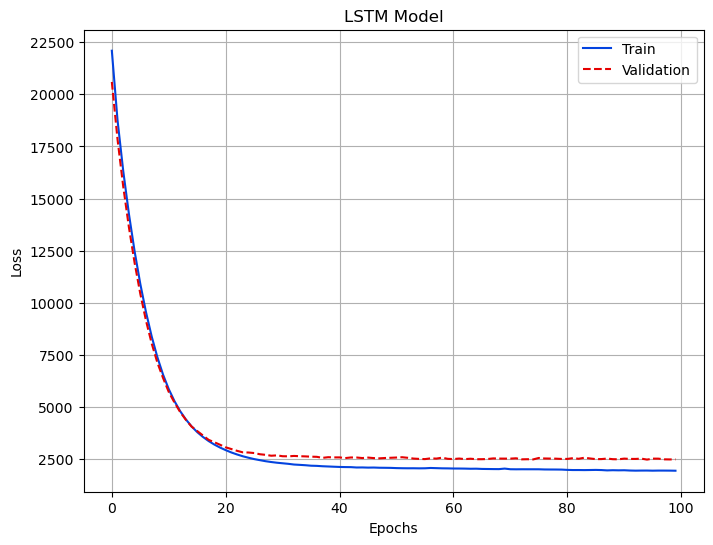

In [76]:
# Plot Train and Val loss
viz.plot_loss(history.history['loss'], history.history['val_loss'], title = 'LSTM Model')

In [77]:
# Make predictions
train_predictions = model.predict(train_data)
val_predictions   = model.predict(val_data)
test_predictions  = model.predict(test_data)

432/432 [==============================] - 3s 7ms/step


In [78]:
y_train[:5]

array([[139.2       , 152.        ],
       [140.6       , 141.        ],
       [137.53333333, 130.        ],
       [124.86666667, 131.        ],
       [116.93333333, 142.        ]])

In [79]:
train_predictions[:5]

array([[129.38487, 141.48029],
       [167.05865, 175.32564],
       [146.63612, 152.05118],
       [155.88803, 160.10504],
       [159.95428, 170.42776]], dtype=float32)

In [91]:
# Make binary predictions
train_pred_labels = np.where(train_predictions < 54, 1, 0)
test_pred_labels  = np.where(test_predictions < 54, 1, 0)
val_pred_labels   = np.where(val_predictions < 54, 1, 0)

In [104]:
train_target = np.where(y_train < 54, 1, 0).all(1).astype(int)
test_target  = np.where(y_test < 54, 1, 0).all(1).astype(int)
val_target   = np.where(y_val < 54, 1, 0).all(1).astype(int)

In [105]:
train_events = train_pred_labels.all(1).astype(int)
test_events  = test_pred_labels.all(1).astype(int)
val_events   = val_pred_labels.all(1).astype(int)

In [129]:
def type_errors(labels, actual):
    TP = ((labels == 1) & (actual == 1)).astype(int)
    TN = ((labels == 0) & (actual == 0)).astype(int)
    FP = ((labels == 1) & (actual == 0)).astype(int)
    FN = ((labels == 0) & (actual == 1)).astype(int)
    
    pos = (actual == 1).sum()
    neg = (actual == 0).sum()
    
    precision = TP/(TP + FP)
    recall    = TP/(TP + FN)
    accuracy  = (TP + TN)/(pos + neg)
    f1score = 2*TP/(2*TP + FP + FN)
    
    return accuracy, precision, recall, f1score

In [132]:
from sklearn.metrics import classification_report

print("Train: \n")
print(classification_report(train_target, train_events))
print("Validation: \n")
print(classification_report(val_target, val_events))
print("Test: \n")
print(classification_report(test_target, test_events))

Train: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     47467
           1       0.00      0.00      0.00       129

    accuracy                           1.00     47596
   macro avg       0.50      0.50      0.50     47596
weighted avg       0.99      1.00      1.00     47596

Validation: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26683
           1       0.00      0.00      0.00        43

    accuracy                           1.00     26726
   macro avg       0.50      0.50      0.50     26726
weighted avg       1.00      1.00      1.00     26726

Test: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13761
           1       0.00      0.00      0.00        43

    accuracy                           1.00     13804
   macro avg       0.50      0.50      0.50     13804
weighted avg       0.99      1.00      1.00

/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kirsh012/opt/anaconda3/envs/tf/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [128]:
(val_target == 1).sum()

43

In [80]:
# def calculate_auc(target, preds, pos_label):
#     fpr, tpr, thresh = roc_curve(target, preds, pos_label=pos_label)
#     auroc = auc(fpr, tpr)
    
#     ppr, rec, thresh = precision_recall_curve(target, preds, pos_label=pos_label)
#     auprc = auc(rec, ppr)
    
#     return auroc, auprc

In [81]:
# train_auc, train_auprc = calculate_auc(y_train, train_predictions, 1)
# val_auc, val_auprc     = calculate_auc(y_val, val_predictions, 1)
# test_auc, test_auprc   = calculate_auc(y_test, test_predictions, 1)

In [82]:
# print("Train AU-ROC: ", train_auc)
# print("Val AU-ROC: ", val_auc)
# print("Test AU-ROC: ", test_auc)

# print("Train AU-PRC: ", train_auprc)
# print("Val AU-PRC: ", val_auprc)
# print("Test AU-PRC: ", test_auprc)

In [83]:
### Plot the traces for Train, Test, Val ###
import matplotlib.pyplot as plt
import seaborn as sns

def legend_without_duplicate_labels(ax):
    '''https://stackoverflow.com/questions/19385639/duplicate-items-in-legend-in-matplotlib'''
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
def plot_traces(real_data, predictions, target, dataset='Train'):
    
    fig, ax = plt.subplots()

    pdx = np.random.choice(range(real_data.shape[0]), size = 1)

    ax.plot(real_data[pdx, :, 0].T, label = f'{dataset} True - Left', linestyle='-', color = 'xkcd:orange')
    ax.plot(real_data[pdx, :, 1].T, label = f'{dataset} True - Right', linestyle='-', color = 'xkcd:pink')

    ax.plot([25], target[pdx,0], marker='o', label = f'{dataset} Actual - Left', color = 'xkcd:green')
    ax.plot([25], target[pdx,1], marker='o', label = f'{dataset} Actual Value - Right', color = 'xkcd:light green')

    ax.plot([25], predictions[pdx, 0], marker='x', label = f'{dataset} Predictions - Left', color = 'xkcd:blue')
    ax.plot([25], predictions[pdx, 1], marker='x', label = f'{dataset} Predictions - Right', color = 'xkcd:black')
    
    ax.set_title(f'{dataset} Traces')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Glucose')
    
    legend_without_duplicate_labels(ax)
    return ax

<AxesSubplot:title={'center':'Val Traces'}, xlabel='Time Points', ylabel='Glucose'>

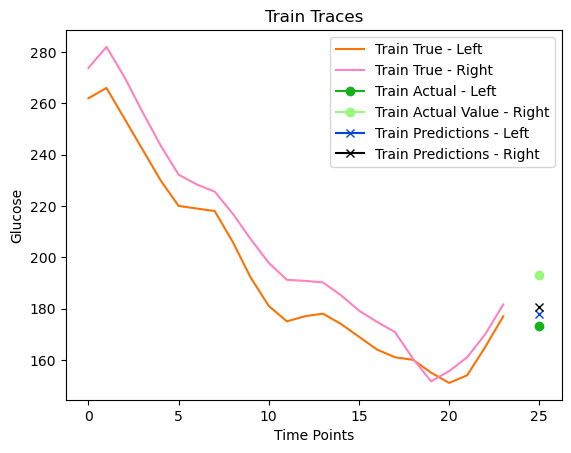

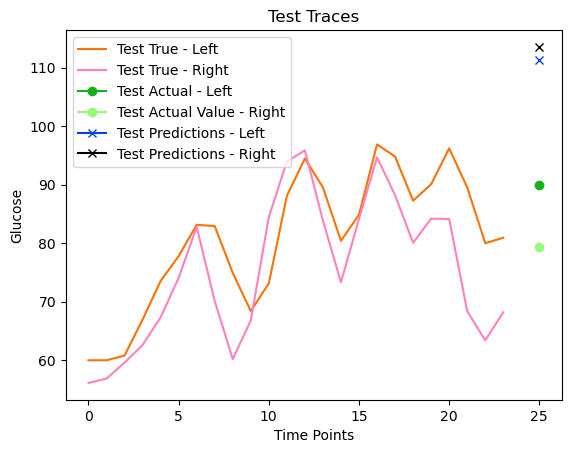

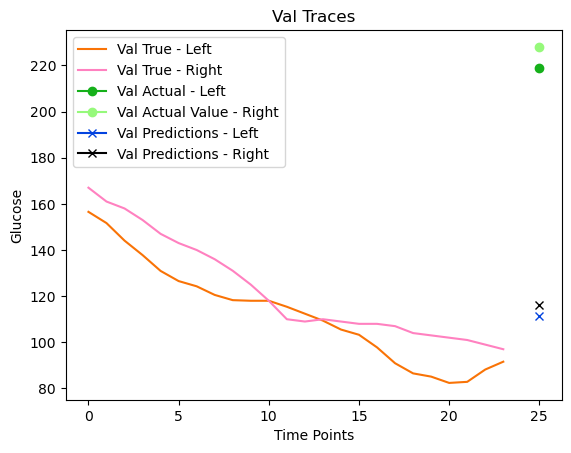

In [86]:
# Train #
plot_traces(train_data, train_predictions, y_train)

# Test #
plot_traces(test_data, test_predictions, y_test, 'Test')

# Validation #
plot_traces(val_data, val_predictions, y_val, 'Val')